https://www.medrxiv.org/content/10.1101/2020.05.01.20088047v1.full.pdf


In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
import ipywidgets as widgets
%load_ext autoreload

In [3]:
%autoreload
import codebase
from codebase.data_generation import *
from codebase.sparse_regression import *
from codebase.utils import *

dataset = CountryDataset()

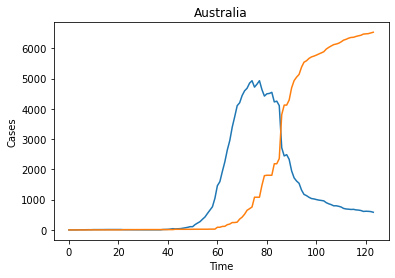

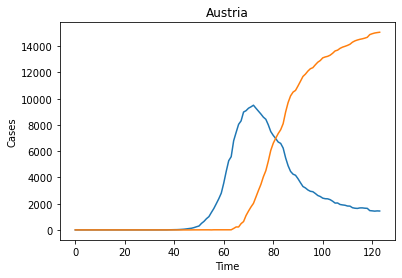

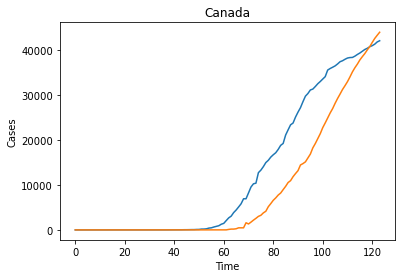

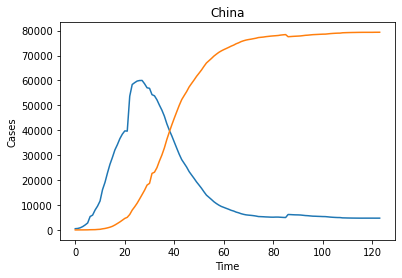

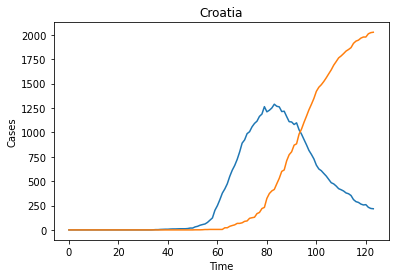

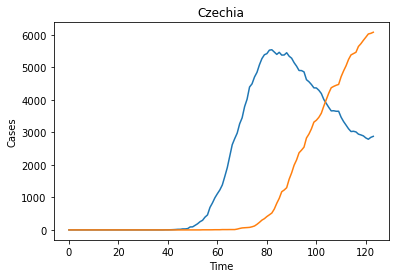

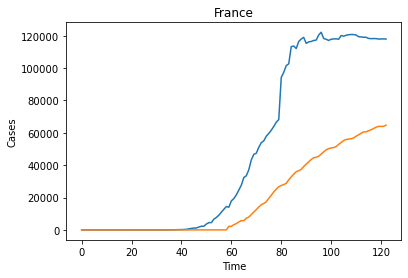

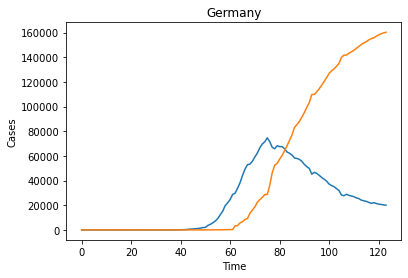

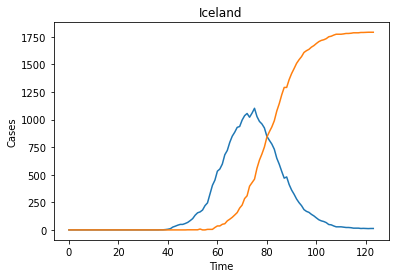

AttributeError: 'NoneType' object has no attribute 'alpha_3'

In [4]:
selected = ['Australia', 'Austria', 'Canada', 'China', 'Croatia', 'Czechia', 'France', 'Germany', 'Iceland', 'Iran', 'Israel', 'Italy', 'Korea, South', 'New Zealand', 'Poland', 'Romania', 'Spain', 'Switzerland', 'Turkey']

for country in selected:
    [susceptible, infected, recovered] = dataset.sir(country).T
    plt.plot(infected, label='infected')
    plt.plot(recovered, label='recovered')
    plt.title(country)
    plt.ylabel('Cases')
    plt.xlabel('Time')
    plt.show()

In [ ]:
rescaling = 1
country = 'China'

[susceptible, infected, recovered] = dataset.sir(country, rescaling).T

plt.plot(infected, label='infected')
plt.plot(recovered, label='recovered')
plt.ylabel('Cases')
plt.xlabel('Time')
plt.show()


In [109]:
sir = dataset.sir(country, 1)/10000
# sir = dataset.cumulative(country, rescaling=1000).reshape(-1, 1)


targets, m1 = make_targets(sir, derivative=(derivative:=False))

augmented, _ = make_polynomials(m1, max_degree=3)

weights, _ = sparse_regression(augmented, m2, cutoff=1e-10)

show_weights(weights, variables=['1', 's', 'i', 'r'], derivative=derivative)

| function   |   $s_{k+1}$ |   $i_{k+1}$ |   $r_{k+1}$ |
|:-----------|------------:|------------:|------------:|
| $1$        | 0           |           0 |           0 |
| $ s$       | 0           |           0 |           0 |
| $ i$       | 0           |           0 |           0 |
| $ r$       | 0           |           0 |           0 |
| $ s^2$     | 0           |           0 |           0 |
| $ s i$     | 0           |           0 |           0 |
| $ s r$     | 0           |           0 |           0 |
| $ i^2$     | 0           |           0 |           0 |
| $ i r$     | 0           |           0 |           0 |
| $ r^2$     | 0           |           0 |           0 |
| $ s^3$     | 0           |           0 |           0 |
| $ s^2 i$   | 1.25586e-06 |           0 |           0 |
| $ s^2 r$   | 8.13703e-07 |           0 |           0 |
| $ s i^2$   | 0           |           0 |           0 |
| $ s i r$   | 0           |           0 |           0 |
| $ s r^2$   | 0           |           0 |           0 |
| $ i^3$     | 0           |           0 |           0 |
| $ i^2 r$   | 0           |           0 |           0 |
| $ i r^2$   | 0           |           0 |           0 |
| $ r^3$     | 0           |           0 |           0 |

[]

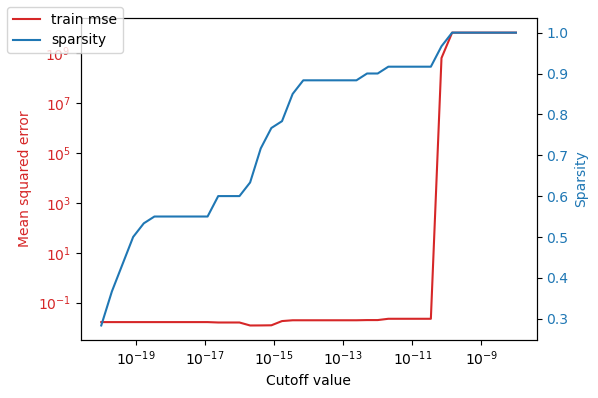

In [111]:
rest = cutoff_mses(augmented, targets, -20, -8)

fig, ax1 = plt.subplots(dpi=100)

color = 'tab:red'
ax1.set_xlabel('Cutoff value')
ax1.set_ylabel('Mean squared error', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(rest['cutoffs'], rest['mses'], color=color, label='train mse')
ax1.tick_params(axis='y')

handles, labels = ax1.get_legend_handles_labels()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Sparsity', color=color)
ax2.plot(rest['cutoffs'], rest['sparsity'], color=color, label='sparsity')
ax2.set_xscale('log')
ax2.tick_params(axis='y', labelcolor=color)
handles2, labels2 = ax2.get_legend_handles_labels()
handles += handles2
labels += labels2

fig.legend(handles, labels, loc='upper left')

fig.tight_layout()
plt.plot()

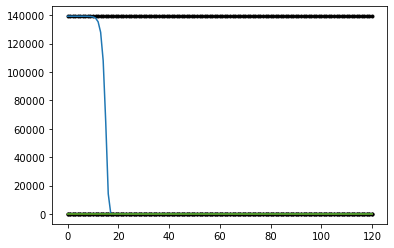

In [113]:
t = range(len(sir))

guess = integrate(rest['all_weights'][0], sir[0], t)

plt.plot(sir, 'k.')
plt.plot(guess)

# Using SIR quantities

We want to use compartmental quantities: 
 - $S$ the number of susceptible people, 
 - $I$ the number of infected, 
 - $R$ the number of recovered people.

Quantities that are available to us:

 - Cumulative cases: $C = I + R = P_{tot} - S$, where $P_{tot}$ is the total population and $C$ is the cumulative number of cases.
 - Recovered cases: $R$

It means that:
 - $S = P_{tot} - C$
 - $I = C - R$


---

<small>In this setting we neglect the fatal cases.</small>
 
 

## Parameter fitting

The most basic compartmental model is the SIR (Susceptible, Infected, Recovered) and is governed by the following dynamics:

\begin{align*}
\frac{dS}{dt} &= -\frac{\beta I S}{N} \\ 
\frac{dI}{dt} &= \frac{\beta I S}{N} - \gamma I \\ 
\frac{dR}{dt} &= \gamma I 
\end{align*}

Where $N$ is the total population, $\beta$ and $\gamma$ are the parameters of the disease.

If we say that:
$
X = 
\begin{bmatrix} 
S \\
I \\
R 
\end{bmatrix}$, 
$
\quad
\frac{d X}{d t}
=
\begin{bmatrix} 
\frac{dS}{dt} \\
\frac{dI}{dt} \\
\frac{dR}{dt}
\end{bmatrix}
$, 
$
\quad
A
= 
\begin{bmatrix} 
-1 & 0  \\
1 & -1 \\
0 & 1 
\end{bmatrix}
\quad
$ and 
$
\quad
\xi = 
\begin{bmatrix} 
\beta \frac{IS}{N} \\
\gamma I
\end{bmatrix}
$ then, we have:
$
\frac{d X}{d t} = A \xi
$.


In [8]:
def fit_parameters(sir,
                   window = 10,
                   step = 1): 
    
    def augment_sir_and_mk_targets(s, i, r, total_pop):
        s_t, i_t, r_t = s[1:], i[1:], r[1:]
        s_f, i_f, r_f = s[:-1], i[:-1], r[:-1]
        isn = s_f*i_f/total_pop
        augmented = np.block([[s_f, i_f, r_f],
                              [-isn, isn, np.zeros_like(s_f)],
                              [np.zeros_like(s_f),-i_f , i_f]])
        targets = np.concatenate([s_t, i_t, r_t]).reshape(-1, 1)
        return augmented.T, targets

    params = []

    for k in range(((len(sir) - window)//step) + 1):
        beginning = k*step
        end = beginning + window
        current_susceptible = sir[beginning:end, 0]
        current_infected = sir[beginning:end, 1]
        current_recovered = sir[beginning:end, 2]
        augmented, targets = augment_sir_and_mk_targets(current_susceptible, current_infected, current_recovered, sir[0, 0])
        [one, beta, gamma] = scipy.optimize.lsq_linear(augmented, targets.reshape(-1), bounds=([0.5, -np.inf, 0.06], [1.5, np.inf, 0.07]))['x']
        params.append([beta, gamma, (current_infected + current_recovered).mean()])

    return np.array(params)

def visualize(country):
    rescaling = 1

    fit_rescaling = 1000

    params = fit_parameters(dataset.sir(country), window=5)
    plot_params = params[(params[:, 2] > 0) & (params[:, 2] < np.inf) & (params[:, 1]*params[:, 0] > 0)]
    plot_params[:, 2] /= fit_rescaling
    
    stringency = dataset.stringency(country)

    f, ax1 = plt.subplots()
    ax1.plot(np.pad(plot_params.T[0]/ plot_params.T[1], (len(stringency)-len(plot_params), 0), 'edge'), label='R0')
    # ax1.plot(plot_params.T[0], label='beta')
    # ax1.plot(plot_params.T[1], label='gamma')
    plt.yscale('log')
    ax2 = ax1.twinx()
    ax2.plot(stringency, 'r')
    # plt.legend()
    plt.plot()
    
widgets.interact(visualize, country=dataset.all_hopkins_countries());


interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.27it/s]
<ipython-input-20-55fff2c9df82>:31: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(r0s, axis=0), 'r', label='mean', linewidth=5.0)
C:\Users\kipr\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


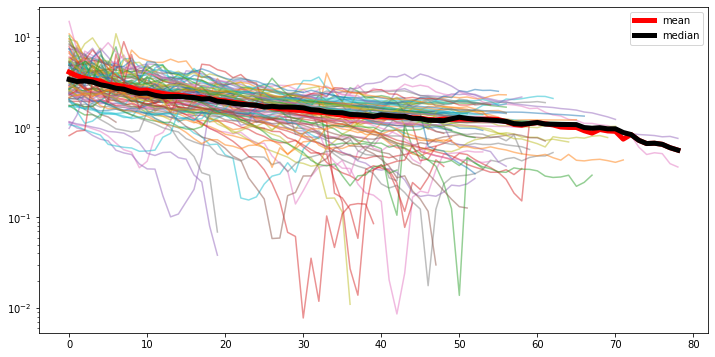

In [20]:
plt.figure(figsize=(12, 6))
r0s = []

for country in tqdm(dataset.all_hopkins_countries()):
    try:
        rescaling = 1

        fit_rescaling = 1000

        params = fit_parameters(dataset.sir(country), window=15)
        plot_params = params[(params[:, 2] > 100) & (params[:, 2] < np.inf) & (params[:, 1]*params[:, 0] > 0)]
        plot_params[:, 2] /= fit_rescaling

#         stringency = dataset.stringency(country)
        info = np.pad(plot_params.T[0]/ plot_params.T[1], (0, 100-len(plot_params)), 'constant', constant_values=(0, np.nan))


        plt.plot(info, alpha=0.5)
        plt.yscale('log')
        r0s.append(info)
    except KeyError:
        pass
    except AttributeError:
        pass
    except ValueError:
        pass
    except np.linalg.LinAlgError:
        pass

r0s = np.array(r0s)
plt.plot(np.nanmean(r0s, axis=0), 'r', label='mean', linewidth=5.0)
plt.plot(np.nanquantile(r0s, 0.5, axis=0), 'k', label='median', linewidth=5.0)

plt.legend()
plt.show()

<ipython-input-18-3a6ee8bad682>:1: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(r0s, axis=0)
<ipython-input-18-3a6ee8bad682>:2: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = np.nanvar(r0s, axis=0)
<ipython-input-18-3a6ee8bad682>:5: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(r0s, axis=0), label='mean')
C:\Users\kipr\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\kipr\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


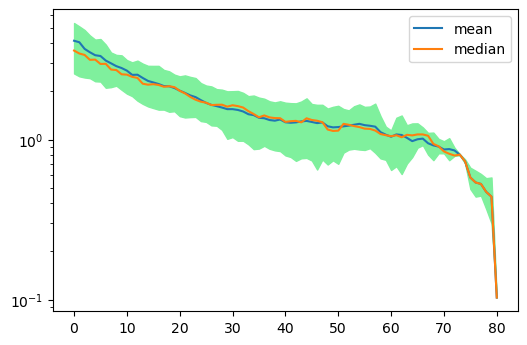

In [18]:
mean = np.nanmean(r0s, axis=0)
var = np.nanvar(r0s, axis=0)

plt.figure(dpi=100)
plt.plot(np.nanmean(r0s, axis=0), label='mean')
plt.plot(np.nanquantile(r0s, 0.5, axis=0), label='median')
plt.fill_between(range(len(mean)), 
                 np.nanquantile(r0s, 0.75, axis=0), 
                 np.nanquantile(r0s, 0.25, axis=0), 
                 color='#7ff09d')
# plt.plot(np.clip(mean - var, a_min=2e-1, a_max=1e2))
plt.yscale('log')
plt.legend()
plt.show()

In [12]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

# def func(t, a, b, c):
#     return a/(1 + np.exp(b*(t - c))), p0=[10, 1, 1]

r0_params, pcov = curve_fit(func, plot_params.T[2], plot_params.T[0]/ plot_params.T[1], maxfev=10000)

plt.plot(plot_params.T[2], func(plot_params.T[2], *r0_params), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(r0_params))
plt.plot(plot_params.T[2], plot_params.T[0]/ plot_params.T[1])

plt.xlabel(f'nb_cases/{fit_rescaling}')
plt.ylabel('R0')
plt.legend()
plt.show()

NameError: name 'plot_params' is not defined

In [ ]:
lin = lambda x, a, b: 0*x + b

gamma_params, pcov = curve_fit(lin, plot_params.T[2], plot_params.T[1])

plt.plot(plot_params.T[2], lin(plot_params.T[2], *gamma_params), 'r-',
#          label='fit: a=%5.3f, b=%5.3f' % tuple(gamma_params)
        )
plt.plot(plot_params.T[2], plot_params.T[1])

plt.xlabel(f'nb_cases/{fit_rescaling}')
plt.ylabel('beta')
plt.legend()
plt.show()

In [ ]:
def new_state(x, weights):
    [s, i, r] = x
    augmentation = np.array([[s, -1, 0],
                             [i, 1, -1],
                             [r, 0, 1]])
    weights[1] *= i*s/total_population
    weights[2] *= i
    return (augmentation @ weights).reshape(-1)

def compute_weights(nb):
    gamma = 0.065 # lin(nb, *gamma_params)
    return np.array([1, min(func(nb, *r0_params), 3)*gamma, gamma])

sir = data.sir(country)
total_population = sir[0, 0]

beginning = 0
trajectory = []
initial_cases = 1
current_state = [total_population-initial_cases, initial_cases, 0]
for k in range(130):
    weights = compute_weights((current_state[1] + current_state[2])/fit_rescaling)
    current_state = new_state(current_state, weights)
    trajectory.append(current_state)
trajectory = np.array(trajectory)

plt.plot(trajectory[:, 1:])
plt.plot(sir[:, 1:])
plt.show()

plt.plot(trajectory[:, 0])
plt.plot(sir[:, 0])
plt.show()

In [ ]:
for country in selected:
    params = fit_parameters(data.get_sir(country))
    plt.plot(params[:, 1])
    plt.title(country)
    plt.show()

## Generated data

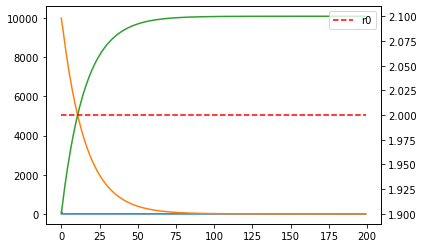

In [116]:
total_population = 1e2
t = np.arange(200)
initial_value = np.array([total_population, 10000, 0])

def r0(t):
    # return min(3., 20*np.exp(-t*0.2)) # + np.random.randn()*0.5
#     if t < 3:
#         return 2.5
#     elif t < 15:
#         return 1.
#     elif t < 20:
#         return 0.8
#     elif t < 40:
#         return 1.1
#     else:
#         return 2.
    return 2

def func(t, x, beta=1.5, gamma=0.065, total_pop=total_population):
    [s, i, r] = x
    isn = gamma*r0(t)*s*i/total_pop
    return np.array([-isn, isn - gamma*i, gamma*i])
                    


res = scipy.integrate.solve_ivp(func, (t[0], t[-1]), initial_value, t_eval=t)

f, ax = plt.subplots()
ax.plot(res.y.T)

ax1 = ax.twinx()

ax1.plot(np.vectorize(r0)(t), 'r--', label='r0')
ax1.legend()

In [117]:
targets, X = make_targets(res.y.T, derivative=(derivative:=False))

augmented, _ = make_polynomials(X, max_degree=3)

learning_limit = 100

weights, _ = sparse_regression(augmented[:learning_limit], targets[:learning_limit], cutoff=5e-6)

show_weights(weights, variables=['1', 's', 'i', 'r'], derivative=derivative)

| function   |   $s_{k+1}$ |   $i_{k+1}$ |   $r_{k+1}$ |
|:-----------|------------:|------------:|------------:|
| $1$        |           0 |           0 |           0 |
| $ s$       |           0 |           0 |           0 |
| $ i$       |           0 |           0 |           0 |
| $ r$       |           0 |           0 |           0 |
| $ s^2$     |           0 |           0 |           0 |
| $ s i$     |           0 |           0 |           0 |
| $ s r$     |           0 |           0 |           0 |
| $ i^2$     |           0 |           0 |           0 |
| $ i r$     |           0 |           0 |           0 |
| $ r^2$     |           0 |           0 |           0 |
| $ s^3$     |           0 |           0 |           0 |
| $ s^2 i$   |           0 |           0 |           0 |
| $ s^2 r$   |           0 |           0 |           0 |
| $ s i^2$   |           0 |           0 |           0 |
| $ s i r$   |           0 |           0 |           0 |
| $ s r^2$   |           0 |           0 |           0 |
| $ i^3$     |           0 |           0 |           0 |
| $ i^2 r$   |           0 |           0 |           0 |
| $ i r^2$   |           0 |           0 |           0 |
| $ r^3$     |           0 |           0 |           0 |

[]

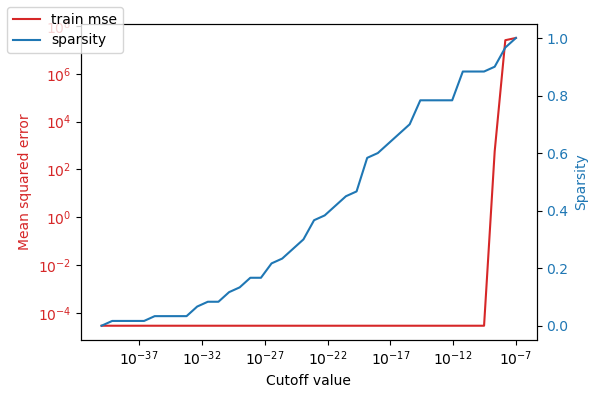

In [121]:
%autoreload

rest = cutoff_mses(augmented, targets, -40, -7)

fig, ax1 = plt.subplots(dpi=100)

color = 'tab:red'
ax1.set_xlabel('Cutoff value')
ax1.set_ylabel('Mean squared error', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(rest['cutoffs'], rest['mses'], color=color, label='train mse')
ax1.tick_params(axis='y')

handles, labels = ax1.get_legend_handles_labels()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Sparsity', color=color)
ax2.plot(rest['cutoffs'], rest['sparsity'], color=color, label='sparsity')
ax2.set_xscale('log')
ax2.tick_params(axis='y', labelcolor=color)
handles2, labels2 = ax2.get_legend_handles_labels()
handles += handles2
labels += labels2

fig.legend(handles, labels, loc='upper left')

fig.tight_layout()
plt.plot()

In [124]:
len(dataset.all_hopkins_countries())

188

In [122]:
learning_limit = 200

weights, _ = sparse_regression(augmented[:learning_limit], targets[:learning_limit], cutoff=2e-11)

show_weights(weights, variables=['1', 's', 'i', 'r'], derivative=derivative)

| function   |   $s_{k+1}$ |   $i_{k+1}$ |   $r_{k+1}$ |
|:-----------|------------:|------------:|------------:|
| $1$        |           0 | 0           | 0           |
| $ s$       |           0 | 0           | 0           |
| $ i$       |           0 | 0           | 0           |
| $ r$       |           0 | 0           | 0           |
| $ s^2$     |           0 | 0           | 0           |
| $ s i$     |           0 | 0           | 0           |
| $ s r$     |           0 | 0           | 0           |
| $ i^2$     |           0 | 0           | 0           |
| $ i r$     |           0 | 0           | 0           |
| $ r^2$     |           0 | 0           | 0           |
| $ s^3$     |           0 | 0           | 0           |
| $ s^2 i$   |           0 | 0           | 0           |
| $ s^2 r$   |           0 | 0           | 0           |
| $ s i^2$   |           0 | 0           | 0           |
| $ s i r$   |           0 | 0           | 0           |
| $ s r^2$   |           0 | 0           | 0           |
| $ i^3$     |           0 | 9.18604e-09 | 6.16934e-10 |
| $ i^2 r$   |           0 | 1.83721e-08 | 1.10368e-08 |
| $ i r^2$   |           0 | 9.18603e-09 | 2.02228e-08 |
| $ r^3$     |           0 | 0           | 9.80296e-09 |

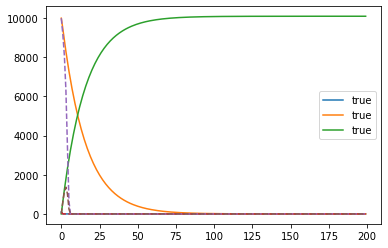

In [123]:

guess = integrate(weights, initial_value, t, derivative=derivative)

plt.plot(res.y.T, label='true')
plt.plot(guess, '--')
plt.legend()
plt.show()

[]

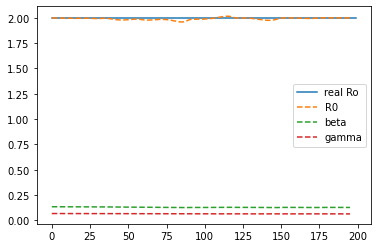

In [56]:
fit_rescaling = 1

params = fit_parameters(res.y.T, window=5)
plot_params = params
plot_params[:, 2] /= fit_rescaling

plt.plot(np.vectorize(r0)(t), label='real Ro')
plt.plot(plot_params.T[0]/ plot_params.T[1], '--', label='R0')
plt.plot(plot_params.T[0], '--', label='beta')
plt.plot(plot_params.T[1], '--', label='gamma')
plt.legend()
# plt.yscale('log')
plt.plot()

100%|████████████| 80/80 [00:00<00:00, 245.16it/s]


[]

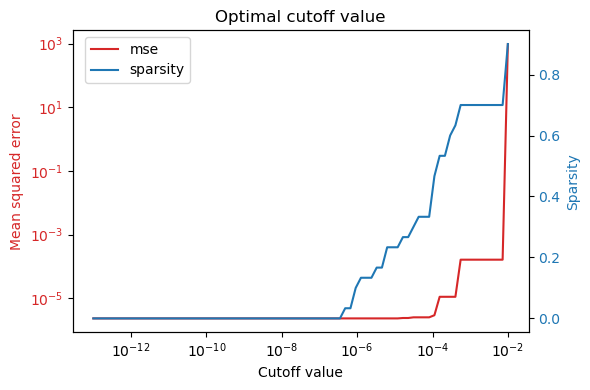

In [37]:
X, dm = augmented, targets

cutoffs = np.logspace(-13, -2, num=80)
sparsity = []
mses = []
all_weights = []

for k in tqdm(cutoffs, ncols=50):
    weights, _ = sparse_regression(X, dm, cutoff=k)
    all_weights.append(weights)
    mse = ((tf.matmul(tf.cast(X, dtype=tf.float32), tf.cast(weights, dtype=tf.float32)) - dm)**2).numpy().mean()
    mses.append(mse)
    sparsity.append((weights.numpy() == 0).sum()/len(weights.numpy().flatten()))

fig, ax1 = plt.subplots(dpi=100)

color = 'tab:red'
ax1.set_xlabel('Cutoff value')
ax1.set_ylabel('Mean squared error', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(cutoffs, mses, color=color, label='mse')
ax1.tick_params(axis='y')

handles, labels = ax1.get_legend_handles_labels()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Sparsity', color=color)  # we already handled the x-label with ax1
# ax2.plot(cutoffs, smapes, color='tab:purple', label='test smape')
ax2.plot(cutoffs, sparsity, color=color, label='sparsity')
ax2.set_xscale('log')
ax2.tick_params(axis='y', labelcolor=color)
handles2, labels2 = ax2.get_legend_handles_labels()
handles += handles2
labels += labels2

fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.13, 0., 0., 0.9))

plt.title('Optimal cutoff value')
fig.tight_layout()
plt.plot()

In [ ]:
show_weights(all_weights[68], variables=['1', 's', 'i', 'r'])

## Raw stringency

In [5]:
stri_cols = ['C1_School closing', 'C1_Flag', 'C2_Workplace closing', 'C2_Flag', 
             'C3_Cancel public events', 'C3_Flag',
             'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
             'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
             'C7_Restrictions on internal movement', 'C7_Flag',
             'C8_International travel controls']

cols = {'variables': ['ConfirmedCases'] + stri_cols,
        'time_dependent_variables': ['ConfirmedCases'] + stri_cols,
        'predicted_variables': ['ConfirmedCases'],
        'max_degree': 3}

[]

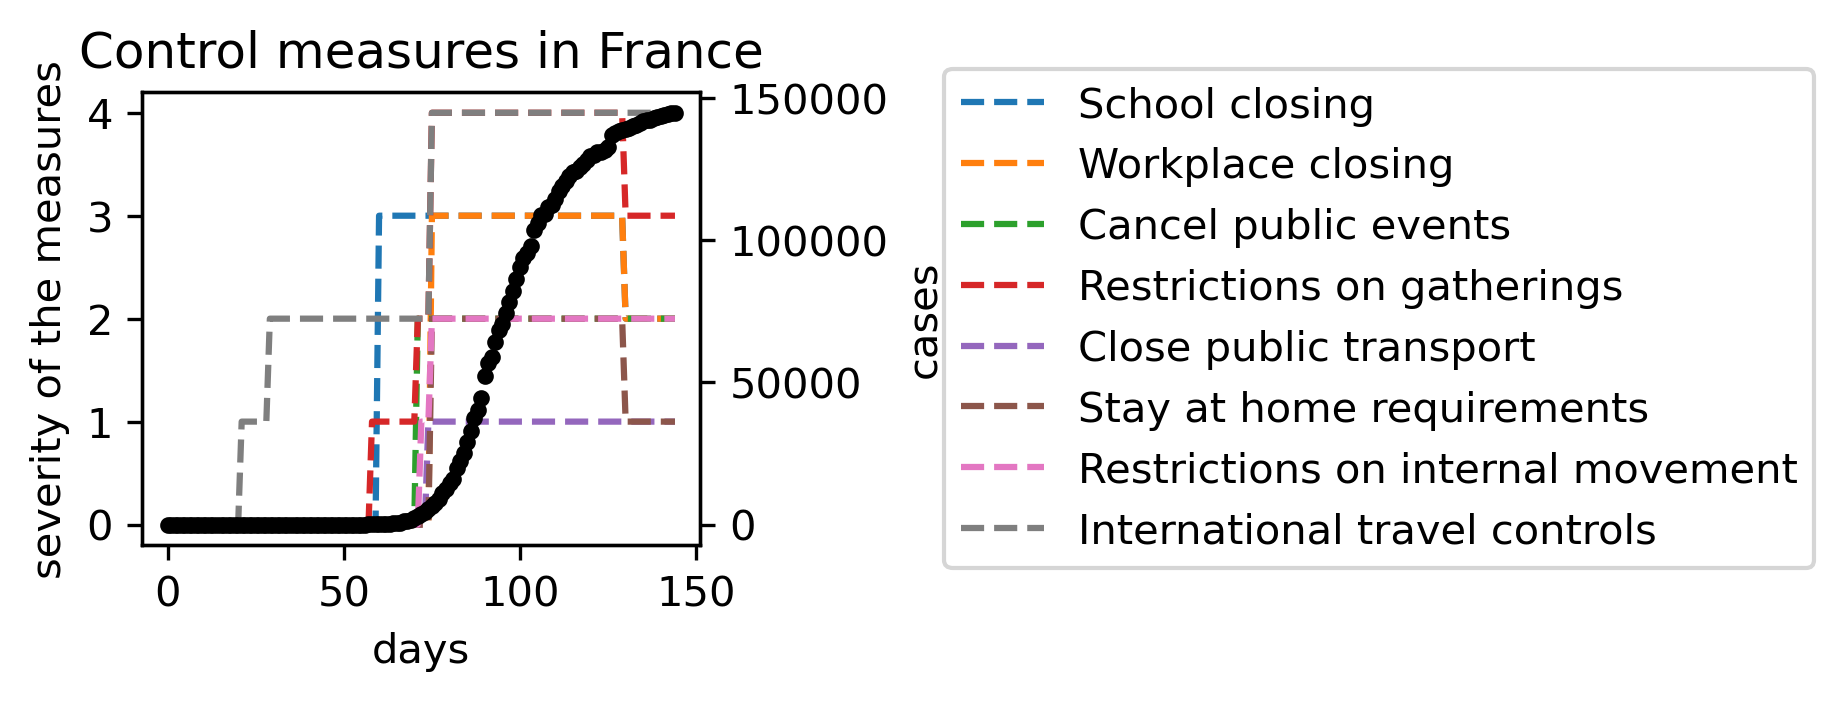

In [11]:
data = dataset.ox_for('France', rescaling=1)

import matplotlib
# matplotlib.rcParams['text.usetex'] = False

fig, ax1 = plt.subplots(dpi=300, figsize=(6, 2))

for col in ['C1_School closing', 'C2_Workplace closing', 
             'C3_Cancel public events',
             'C4_Restrictions on gatherings', 'C5_Close public transport',
             'C6_Stay at home requirements',
             'C7_Restrictions on internal movement',
             'C8_International travel controls']:
    ax1.plot(data[[col]].values, '--', label=col[3:])

ax1.legend(loc='center left', bbox_to_anchor=(1.4, 0.5))
ax2 = ax1.twinx()
ax2.plot(data[['ConfirmedCases']].values, 'k.', label='Cases')
ax1.set_xlabel('days')
ax1.set_ylabel('severity of the measures')
ax2.set_ylabel('cases')
plt.title('Control measures in France')

box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.4, box.height])
plt.savefig('control.png', dpi=200)
plt.plot()

In [12]:
country = "Portugal"

m2, m1 = make_targets_df(dataset.ox_for(country, rescaling=1000))

augmented, integration_args = make_polynomials_df(m1, **cols)

weights, _ = sparse_regression(augmented, m2[cols['predicted_variables']].values, cutoff=5e-4)
# integration_args['weights'] = weights
# weights

100%|█████████████| 10/10 [00:00<00:00, 92.18it/s]


[]

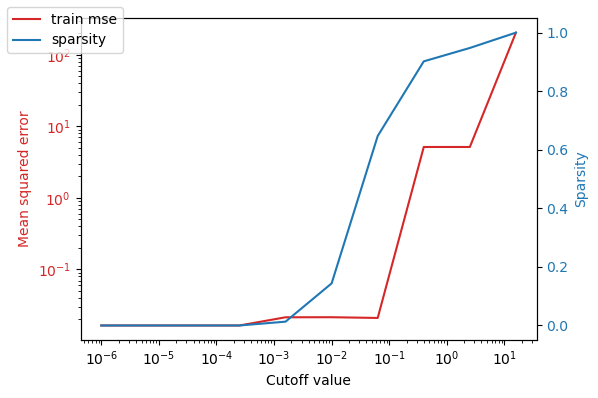

In [13]:
cutoffs = np.logspace(-6, 1.2, num=10)
sparsity = []
mses = []
all_weights = []

for k in tqdm(cutoffs, ncols=50):
    weights, _ = sparse_regression(augmented, m2[cols['predicted_variables']].values, cutoff=k)
    mse = ((tf.matmul(tf.cast(augmented, dtype=tf.float32), tf.cast(weights, dtype=tf.float32)) - m2[cols['predicted_variables']].values)**2).numpy().mean()
    mses.append(mse)
    sparsity.append((weights.numpy() == 0).sum()/len(weights.numpy().flatten()))
    all_weights.append(weights)

fig, ax1 = plt.subplots(dpi=100)

color = 'tab:red'
ax1.set_xlabel('Cutoff value')
ax1.set_ylabel('Mean squared error', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(cutoffs, mses, color=color, label='train mse')
ax1.tick_params(axis='y')

handles, labels = ax1.get_legend_handles_labels()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Sparsity', color=color)
ax2.plot(cutoffs, sparsity, color=color, label='sparsity')
ax2.set_xscale('log')
ax2.tick_params(axis='y', labelcolor=color)
handles2, labels2 = ax2.get_legend_handles_labels()
handles += handles2
labels += labels2

fig.legend(handles, labels, loc='upper left')

fig.tight_layout()
plt.plot()
# plt.savefig('sparsity_vs_mse.png', dpi=100)


In [141]:
candidates = [(e, i) for i, e in enumerate(zip(mses, cutoffs))]
def select_weights(a):
    country_data = m1
    t = range(len(country_data.index) + (extrapolation:=40))
    high_data = country_data[country_data['ConfirmedCases'] > 1]
    real_t = len(high_data.index)
    guess = integrate_df(real_trajectory=high_data, extrapolation=extrapolation, **integration_args, **cols, weights=all_weights[a])
    plt.plot(t[:-extrapolation], country_data['ConfirmedCases'], 'k.', label='real data')
    plt.plot(t[-real_t-extrapolation:], guess[:, 0], label='predictions')
    plt.legend()
    plt.title(country)
    plt.show()

_ = widgets.interact(select_weights, a=candidates)

interactive(children=(Dropdown(description='a', options=(((0.44873106, 1e-06), 0), ((0.44873106, 1.40261595740…

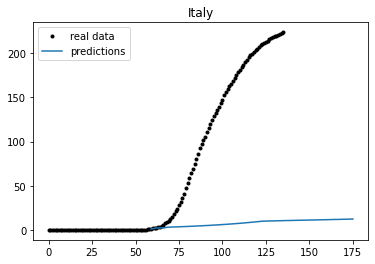

In [131]:
country_data = m1
t = range(len(country_data.index) + (extrapolation:=40))
high_data = country_data[country_data['ConfirmedCases'] > 1]
real_t = len(high_data.index)
guess = integrate_df(real_trajectory=high_data, extrapolation=extrapolation, **integration_args, **cols)
plt.plot(t[:-extrapolation], country_data['ConfirmedCases'], 'k.', label='real data')
plt.plot(t[-real_t-extrapolation:], guess[:, 0], label='predictions')
plt.legend()
plt.title(country)
plt.show()
